__Federated Learning__



In [12]:
import itertools
import random

import numpy
import sklearn.metrics
import torch
from torch import Tensor
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tqdm
from matplotlib import pyplot as plt

# from models import LogisticRegressionModel
# from Tensor import Tensor

device = "cuda" if torch.cuda.is_available() else "cpu"

__Data Preprocessing__

In [54]:
device = torch.device(f'cuda:{torch.cuda.current_device()}') if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)
torch.set_default_dtype(torch.float32)
torch.set_grad_enabled(True)

In [55]:
df = pd.read_csv("mushrooms.csv")
df = pd.get_dummies(df, drop_first=True).astype(float)
y = df.class_p
X = df.drop('class_p', axis=1)
X.insert(0, "bias", np.ones(X.shape[0]))
X_train, X_test, y_train, y_test = (
    Tensor(i.to_numpy()).to(device) for i in train_test_split(X, y, test_size=0.33, random_state=239)
)

y_train = y_train.reshape(-1, 1)

In [56]:
import math

class LogisticRegression:
    
    def __init__(self, X_train, y_train):
        self.weight: Tensor = torch.zeros(y_train.shape[1], X_train.shape[1], requires_grad=True).to(device)
        self.X_train = X_train
        self.y_train = y_train
    
    @staticmethod
    def logistic(z: Tensor) -> Tensor:
        return 1 / (1 + torch.exp(-z))

    @staticmethod
    def logistic_reg_model(X: Tensor, w: Tensor) -> Tensor:
        return LogisticRegression.logistic(X @ w.t())
    
    @staticmethod
    def binary_cross_entropy(predicted: Tensor, true: Tensor) -> Tensor:
        return -(true * predicted.log() + (1 - true) * (1 - predicted).log()).mean()
    
    def forward_pass(self) -> None:
        predictions = LogisticRegression.logistic_reg_model(self.X_train, self.weight)
        loss = entropy=LogisticRegression.binary_cross_entropy(predictions, self.y_train)
        loss.backward()
        return predictions
    
    def predict(self, X) -> Tensor:
        with torch.no_grad():
            wet_predictions = LogisticRegression.logistic_reg_model(X, self.weight)
            return torch.round(wet_predictions)

In [57]:
import matplotlib.pyplot as plt

def naiveGD_LG(epochs, learning_rate, X_train, y_train, X_test, y_test):
    accuracy_history = []
    model = LogisticRegression(X_train, y_train)
    for _ in tqdm.tqdm(range(epochs)):
        model.forward_pass()
        with torch.no_grad():
            update = -1 * learning_rate * model.weight.grad
            model.weight += update
            classes = model.predict(X_test)
            accuracy_history.append(
                accuracy_score(
                    y_test.to("cpu"), 
                    classes.to("cpu")
                )
            )
            model.weight.grad.zero_()
    return accuracy_history
accuracy_history_GD_LG = naiveGD_LG(1000, 0.1, X_train, y_train, X_test, y_test)

100%|██████████| 1000/1000 [00:02<00:00, 377.37it/s]


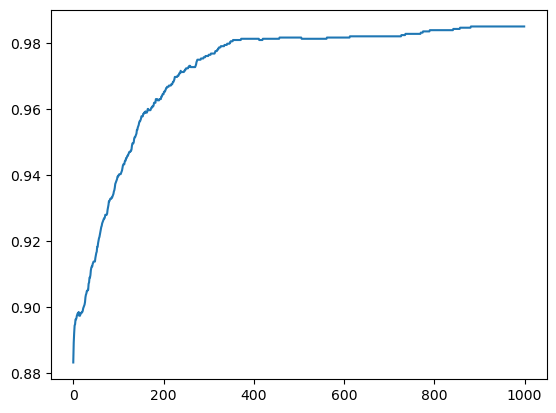

In [58]:
plt.plot(accuracy_history_GD_LG)

In [131]:
import time

class Division:
    amount: int
    prob: float
    def __init__(self, amount, prob):
        self.amount = amount
        self.prob = prob
        
    def __str__(self):
        return f"Division({self.amount}, {self.prob})"

def getLearningData(X_train, y_train, division: Division):
    idx = []
    for i in range(division.amount):
        sample = 1.0 if random.random() < division.prob else 0.0
        while True:
            index = random.randint(0, y_train.size()[0] - 1)
            if y_train[index].item() == sample:
                idx.append(index)
                break
    return X_train[idx], y_train[idx]
                    
    

def L2GD(nodesAmount, probabilities, lambdas, X_train, y_train, divisions: list[Division]):
    alpha = 0.1
    iterations = 1000 
    history = np.zeros((5, 5, iterations, nodesAmount + 1))
    for probability, lam in tqdm.tqdm(itertools.product(probabilities, lambdas)):
        coeff = alpha * lam / nodesAmount / probability
        assert coeff < 1 / 2
        
        nodes: list[LogisticRegression] = [
            LogisticRegression(
                *getLearningData(X_train, y_train, divisions[i])
            )
            for i in range(nodesAmount)
        ]

        for k in range(iterations):
            if not random.random() < probability or k == 0:
                for node in nodes:
                    if not node.weight.requires_grad:
                        print(k)
                        return 
                    node.forward_pass()
                    if np.NAN in node.weight.grad:
                        return
                    with torch.no_grad():
                        update = -1 * alpha * node.weight.grad
                        node.weight += update
                    if torch.nan in node.weight.grad:
                        print("AAAA")
                    node.weight.grad.zero_()
            else:
                with torch.no_grad():
                    average = sum(node.weight for node in nodes) / nodesAmount
                    for node in nodes:
                        delta = ((1 - coeff) * node.weight + coeff * average) - node.weight
                        node.weight += delta
                        node.weight.grad.zero_()

            # MID EVALUATION
            with torch.no_grad():
                prob_index = np.where(probabilities == probability)
                lam_index = np.where(lambdas == lam)

                for i in range(len(nodes)):
                    node = nodes[i]
                    y_pred = node.predict(X_test)
                    try:
                        score = accuracy_score(
                            y_test.to("cpu"),
                            y_pred.to("cpu")
                        )
                        history[prob_index, lam_index, k, i] = score
                    except Exception:
                        print("BBB")
                        print(node.weight)
                        print(delta)
                        print(k)

                average = sum(node.weight for node in nodes) / nodesAmount
                av_model = LogisticRegression(X_train, y_train)
                av_model.weight += average
                y_pred = av_model.predict(X_test)
                if torch.nan in y_pred:
                    print(av_model.weight)
                    return
                score = accuracy_score(
                    y_test.to("cpu"),
                    y_pred.to("cpu")
                )
                history[prob_index, lam_index, k, nodesAmount] = score
    return history


nodes_amount = 10
probabilities = np.linspace(0.1, 0.5, 2)
lambdas = np.linspace(1e-5, 0.1, 2)

divisions = [
    Division(
        random.randint(0, X_train.size()[0] * 2),
        random.random()
    )
    for i in range(nodes_amount)
]
print(*divisions)
history = L2GD(nodes_amount, probabilities, lambdas, X_train, y_train, divisions)

Division(4669, 0.5724289174238093) Division(339, 0.13983243921415578) Division(5274, 0.05134380071010802) Division(456, 0.10742657232325314) Division(2633, 0.2537507146930179) Division(7497, 0.39285450563394475) Division(1390, 0.5364348553069078) Division(4092, 0.9539345185353301) Division(1453, 0.8401757808874274) Division(163, 0.4132987626094994)


4it [01:37, 24.30s/it]


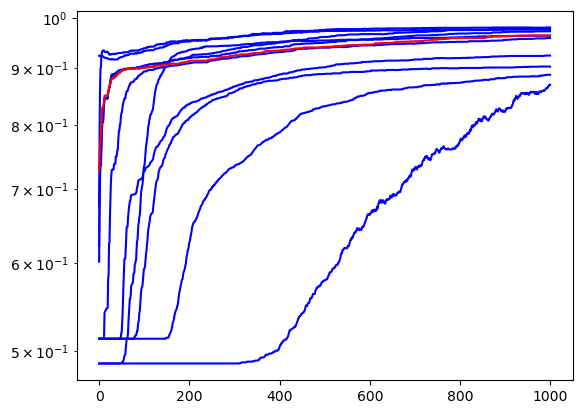

In [132]:
for i in range(nodes_amount+ 1):
    i_th_node_history = history[1, 1, :, i]
    color_plot = 'red' if i == nodes_amount else 'blue'
    plt.yscale("log")
    plt.plot(i_th_node_history, color = color_plot)